# Stock Recommendation Sysytem using Twitter Sentimental Analysis

## Data 228 Term Project

Janani Ravikumar, <br/>
Harshitha Mohanraj Radhika, <br/>
Rohan Naga Venkata Mayukh Ungarala

## Importing required libraries and packages
The Yahoo Finance API is a range of libraries/APIs/methods to obtain historical and real time data for a variety of financial markets and products, as shown on Yahoo Finance. <br/>
Tweepy is an open source Python package that gives a very convenient way to access the Twitter API with Python. Tweepy includes a set of classes and methods that represent Twitter's models and API endpoints, and it transparently handles various implementation details, such as: Data encoding and decoding.<br/>
The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators. <br/>
TextBlob employs the “averaging” technique, which is applied to polarity values to calculate a polarity score for a single word, and thus a similar procedure applies to every single word, resulting in a combined polarity for larger texts. <br/>
NLTK, or Natural Language Toolkit, is a Python package that used for NLP. A lot of the data that could be analyzing is unstructured data and contains human-readable text. Before analyze that data programmatically, we first need to preprocess it. <br/>

In [0]:
import datetime as dt
import math

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression as LR
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob

import time
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Out[84]: True

## Defining Class Tweet
The retrieved list of the last 500 tweets posted in english containing the symbol introduced and they are later stored in a list of Tweet class, defined below with the tweet's text and polarity from TextBlob.

In [0]:
class Tweet(object):

    def __init__(self, content, polarity):
        self.content = content
        self.polarity = polarity

## Function module to check company stock symbol
check_stock_symbol function inputs companylist.csv and verifies if the given symbol is present in the company list csv file else throws error. We have used a csv file with a total 3428 companies and their stock symbols

In [0]:
def check_stock_symbol(symbol, flag=False, companies_file='companylist.csv'):
    df = pd.read_csv(companies_file, usecols=[0])
    valid_symbols = set(df['Symbol'])

    if symbol in valid_symbols:
        flag = True
        
    return flag, symbol

## Function module to fetch stock data from yahoo finance
get_stock_data function retrieves data from yfinance module and converts into a dataframe with columns 'Open', 'High', 'Low', 'Close' and 'Volume'. The Highload and change are calculated from the fetched values. Highload is the percentage in the peak of the stock value compared to the closing value. 'Change' is the percentage of the closed value comapring the open value of the stock

In [0]:
def get_stock_data(symbol, from_date, to_date):
    FinData = yf.download(symbol, start=from_date, end=to_date)
    data_df = pd.DataFrame(data=FinData)

    data_df = data_df[['Open', 'High', 'Low', 'Close', 'Volume']]
    data_df['HighLoad'] = (data_df['High'] - data_df['Close']) / data_df['Close'] * 100.0
    data_df['Change'] = (data_df['Close'] - data_df['Open']) / data_df['Open'] * 100.0

    data_df = data_df[['Close', 'HighLoad', 'Change', 'Volume']]
    return data_df

## Function module to forecast stock value using Linear Regression model
We split the dataset into random train and test data using randomSplit with 70% training and 30% testing data. The machine learning algorithm Linear Regression is used to forecst the data. The stock close value is considered as the label for the dataset and is compared with the features column generated.

In [0]:
def stock_forecasting(data_df):
    forecast_col = 'Close'
    forecast_out = int(math.ceil(0.1*len(data_df)))
    data_df['Label'] = data_df[[forecast_col]].shift(-forecast_out)

    spark = SparkSession.builder.master("local[1]").appName("SentimentAnalysis").getOrCreate()
    sparkDf = spark.createDataFrame(data_df)

    feature_columns = ['Close', 'HighLoad', 'Change', 'Volume']
    assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
    sparkDf = assembler.transform(sparkDf)

    X = np.array(data_df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    data_df.dropna(inplace=True)
    y = np.array(data_df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    train, test = sparkDf.randomSplit([0.7, 0.3], seed = 2018)

    model = LinearRegression(featuresCol="features", labelCol="Label")
    #Linear Regression Using scikit api
    clf = LR(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test) * 100
    forecast = clf.predict(X_forecast)

    data_df['Prediction'] = np.nan

    last_date = data_df.iloc[-1].name
    last_date = dt.datetime.strptime(str(last_date), "%Y-%m-%d %H:%M:%S")

    for pred in forecast:
        last_date += dt.timedelta(days=1)
        data_df.loc[last_date.strftime("%Y-%m-%d")] = [np.nan for _ in range(len(data_df.columns) - 1)] + [pred]
    return data_df, forecast_out, accuracy

## Displaying sparkDf dataframe with Label and Features column

In [0]:
sparkDf.show(10)

+------------------+------------------+--------------------+--------+------------------+--------------------+
|             Close|          HighLoad|              Change|  Volume|             Label|            features|
+------------------+------------------+--------------------+--------+------------------+--------------------+
| 43.61000061035156|4.6778282205369095|   -4.46878608398484| 9204200| 46.65999984741211|[43.6100006103515...|
| 43.45000076293945|1.4039139232233586|  -1.182625524965488| 8279600| 47.91999816894531|[43.4500007629394...|
| 42.90999984741211|1.7012340825733052|-0.06986208722935437| 7222900| 48.79999923706055|[42.9099998474121...|
|42.189998626708984|1.4221434186976232| -0.5656414724030074| 7390000|49.040000915527344|[42.1899986267089...|
|42.290000915527344|1.1586612749152765|-0.40037252145744795| 5076100| 49.08000183105469|[42.2900009155273...|
|  43.5099983215332|2.7350091641288685| -0.5712980109438927|12150000| 47.33000183105469|[43.5099983215332...|
|  43.9900

## Function module to retrieve tweets and calculate polarity
The tweets are retrieved using API_key, Access token, API_secret key and Access token secret by creating twitter developer account. Text Blob is imported, When computing a sentiment for a single word, TextBlob employs the “averaging” technique, which is applied to polarity values to calculate a polarity score for a single word, and thus a similar procedure applies to every single word, resulting in a combined polarity for larger texts.

In [0]:
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth)

    #tweets = tweepy.Cursor(user.search_tweets, q=symbol, tweet_mode='extended', lang='en').items(num_of_tweets)
    tweets = user.search_tweets(q=symbol, tweet_mode="extended", count=num_of_tweets)

    tweet_list = []
    global_polarity = 0
    for tweet in tweets:
        tw = tweet.full_text
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(Tweet(tw, polarity))

    global_polarity = global_polarity / len(tweet_list)
    return global_polarity

## Function to Print Stock Recommendation based on Polarity

In [0]:
def recommending(df, forecast_out, global_polarity, accuracy):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea! With an accuracy of %.2f%%" % (str(symbol), accuracy))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea! With an accuracy of %.2f%%" % (str(symbol), accuracy))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea! With an accuracy of %.2f%%" % (str(symbol), accuracy))

## Function Module to plot forecasted stock value of a particular company

In [0]:
def forecast_plot(df):
    plt.figure(figsize=(20, 8))
    df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

## Generated Access and API tokens from twitter developer account

In [0]:
consumer_key = 'ziBlCmVP1PykVYzBxLs42Bmxk'
consumer_secret = '7Hh941oxioJzCW4rDIs5BIvNrZY7L8GJP3zgZkSGj6KxAZqFrA'
access_token = '1526609173399474176-PetZoHtZWgCWMkmGrxLq5bH8ukunMc'
access_token_secret = 'G8JzgCZiTDFMeIw3ONnztgiDct8YIbd7c5j1cSEVIo766'

num_of_tweets = 500

## Calling the Function module to generate recommendation based on prediction & polarity

In [0]:
def GetRecommendation(symbol):
    actual_date = dt.date.today()
    past_date = actual_date - dt.timedelta(days=365 * 3)

    actual_date = actual_date.strftime("%Y-%m-%d")
    past_date = past_date.strftime("%Y-%m-%d")

    print ("Retrieving Stock Data from introduced symbol")
    dataframe = get_stock_data(symbol, past_date, actual_date)
    print ("Forecasting stock DataFrame")
    (dataframe, forecast_out, accuracy) = stock_forecasting(dataframe)
    print ("Plotting existing and forecasted values")
    forecast_plot(dataframe)
    polarity = retrieving_tweets_polarity(symbol)
    print ("Generating recommendation based on prediction & polarity")
    recommending(dataframe, forecast_out, polarity, accuracy)

## Plotting existing and forecasted values for the company Apple 'AAPL'

Retrieving Stock Data from introduced symbol
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame
Plotting existing and forecasted values


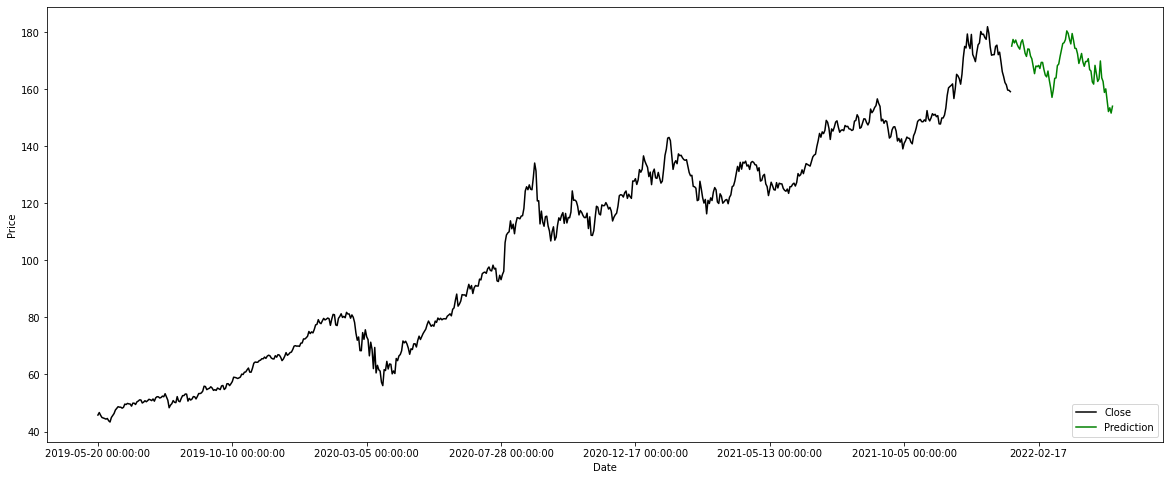

Generating recommendation based on prediction & polarity
According to the predictions and twitter sentiment analysis -> Investing in AAPL is a BAD idea! With an accuracy of 87.73%


In [0]:
symbol = 'AAPL'
GetRecommendation(symbol)

## Plotting existing and forecasted values for the company Amazon 'AMZN'

Retrieving Stock Data from introduced symbol
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame
Plotting existing and forecasted values


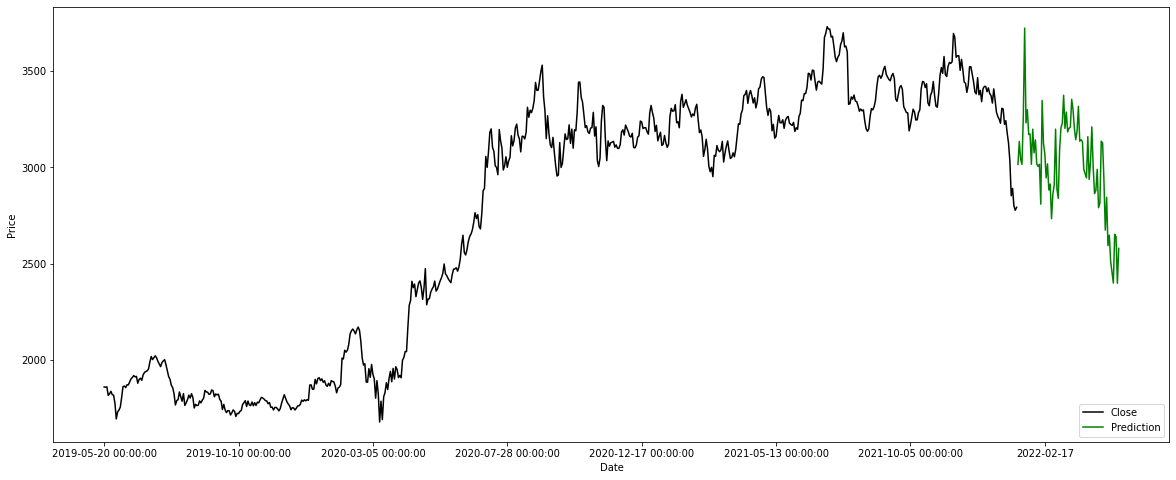

Generating recommendation based on prediction & polarity
According to the predictions and twitter sentiment analysis -> Investing in AMZN is a BAD idea! With an accuracy of 70.77%


In [0]:
symbol = 'AMZN'
GetRecommendation(symbol)

## Plotting existing and forecasted values for the company Tesla 'TSLA'

Retrieving Stock Data from introduced symbol
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame
Plotting existing and forecasted values


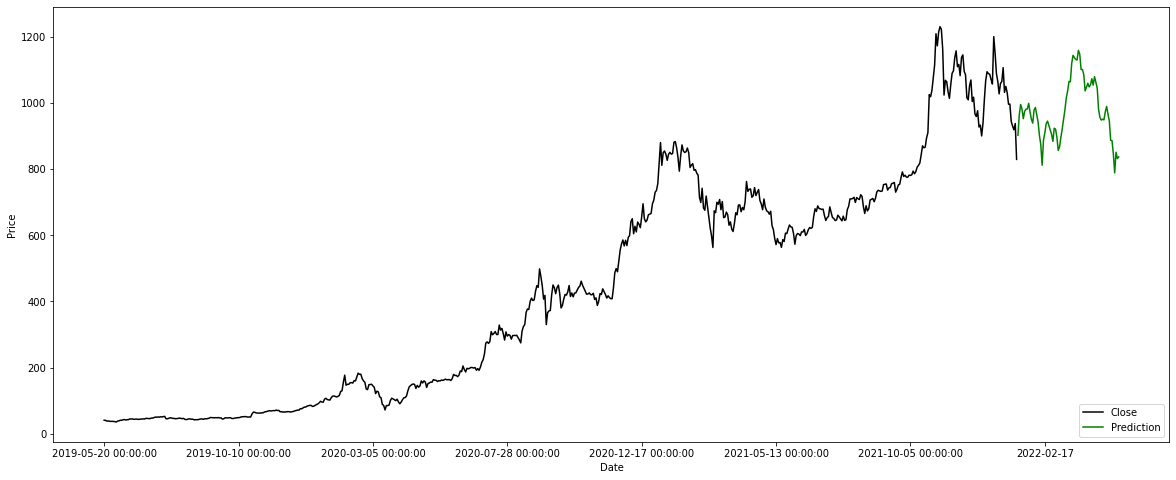

Generating recommendation based on prediction & polarity
According to the predictions and twitter sentiment analysis -> Investing in TSLA is a GREAT idea! With an accuracy of 75.56%


In [0]:
symbol = 'TSLA'
GetRecommendation(symbol)

## Plotting existing and forecasted values for the company Microsoft 'MSFT'

Retrieving Stock Data from introduced symbol
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame
Plotting existing and forecasted values


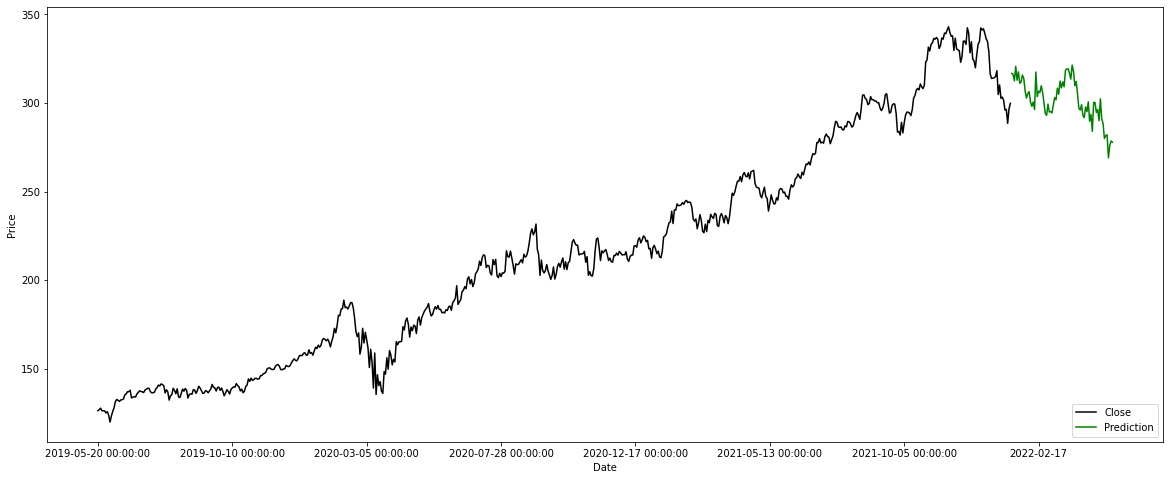

Generating recommendation based on prediction & polarity
According to the predictions and twitter sentiment analysis -> Investing in MSFT is a BAD idea! With an accuracy of 83.70%


In [0]:
symbol = 'MSFT'
GetRecommendation(symbol)

In [0]:
## Plotting existing and forecasted values for the company Advanced Micro Devices 'AMD'

Retrieving Stock Data from introduced symbol
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame
Plotting existing and forecasted values


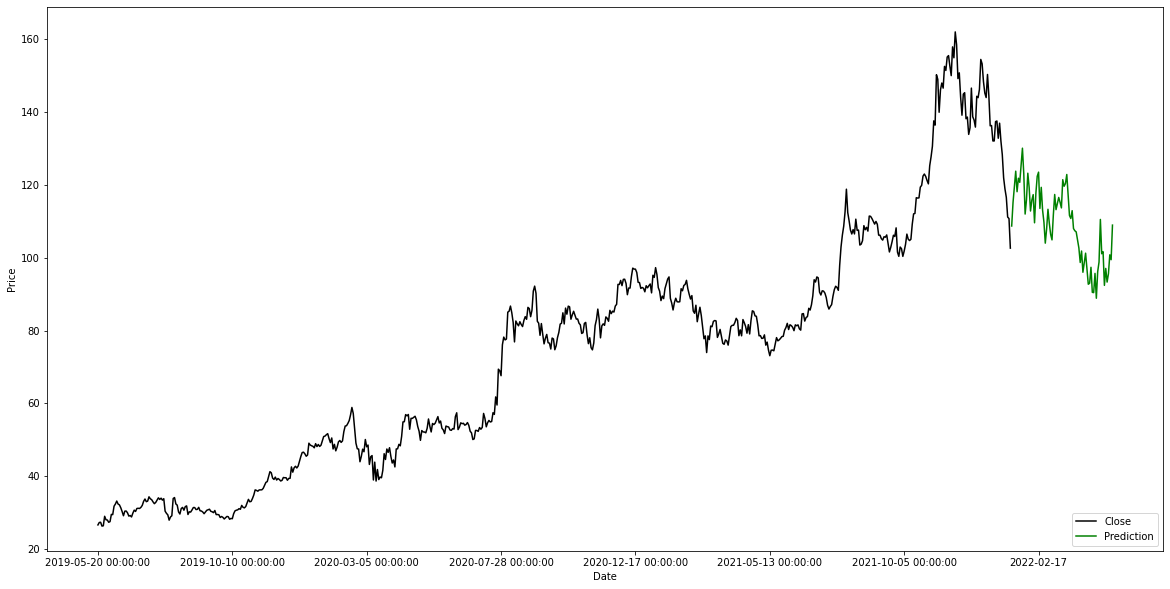

Generating recommendation based on prediction & polarity
According to the predictions and twitter sentiment analysis -> Investing in AMD is a GREAT idea! With an accuracy of 61.30%


In [0]:
symbol = 'AMD'
GetRecommendation(symbol)